In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, AdamW
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

## Load and resize the images

In [3]:
IMAGE_LIB = '/kaggle/input/finding-lungs-in-ct-data/2d_images/'
MASK_LIB = '/kaggle/input/finding-lungs-in-ct-data/2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 224, 224
SEED=42

In [4]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

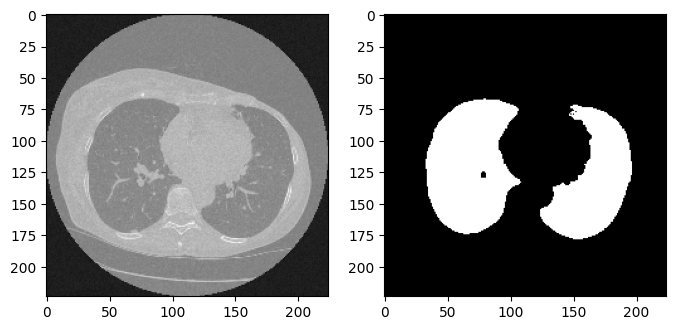

In [5]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[3], cmap='gray')
ax[1].imshow(y_data[3], cmap='gray')
plt.show()

In [6]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.3)

In [9]:
x_data.shape

(267, 224, 224, 1)

## Define and train model

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
def unet_model(input_size=(224, 224, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the U-Net model
model = unet_model(input_size=(224, 224, 1))

model = unet()
model.summary()

In [ ]:
import albumentations as A
import numpy as np

# Define the augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(width=IMG_WIDTH, height=IMG_HEIGHT, p=1.0),  # Adjust dimensions as needed
    A.Rotate(limit=15, p=0.5),  # Rotate by up to +/- 15 degrees
    A.ShiftScaleRotate(shift_limit=0, scale_limit=(0.15, 0.35), rotate_limit=0, p=1.0),
    A.GaussNoise(var_limit=0.01, p=0.25),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),  
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.GaussianBlur(p=0.25),
    A.Sharpen(p=0.25),
#     A.Cutout(num_holes=4, max_h_size=16, max_w_size=16, p=0.5),
    A.CoarseDropout(max_holes=4, max_height=16, max_width=16, fill_value=1, p=0.5)
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0)
])


def my_generator(x_train, y_train, batch_size):
    while True:
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        batch_x = x_train[idx]
        batch_y = y_train[idx]

        batch_x_aug = np.zeros_like(batch_x)
        batch_y_aug = np.zeros_like(batch_y)

        for i in range(batch_x.shape[0]):
            augmented = augmentation(image=batch_x[i], mask=batch_y[i])
            batch_x_aug[i] = augmented['image']
            batch_y_aug[i] = augmented['mask']

        yield batch_x_aug, batch_y_aug

In [ ]:
import albumentations as A
import numpy as np

# Define the validation augmentation pipeline
validation_augmentation = A.Compose([
    A.Resize(width=IMG_WIDTH, height=IMG_HEIGHT, p=1.0),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=(0.25, 0.25), rotate_limit=0, p=1.0)
])

def my_validation_generator(x_val, y_val, batch_size):
    while True:
        idx = np.random.randint(0, x_val.shape[0], batch_size)
        batch_x = x_val[idx]
        batch_y = y_val[idx]

        batch_x_aug = np.zeros_like(batch_x)
        batch_y_aug = np.zeros_like(batch_y)

        for i in range(batch_x.shape[0]):
            augmented = validation_augmentation(image=batch_x[i], mask=batch_y[i])
            batch_x_aug[i] = augmented['image']
            batch_y_aug[i] = augmented['mask']

        yield batch_x_aug, batch_y_aug


By using the same RNG seed in both calls to ImageDataGenerator, we should get images and masks that correspond to each other. Let's check this, to be safe.

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [ ]:
image_batch, mask_batch = next(my_validation_generator(x_val, y_val, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [ ]:
y_train.shape

In [ ]:
model.compile(optimizer=AdamW(2e-4), loss='binary_crossentropy', metrics=[dice_coef, 'accuracy'])

In [ ]:
weight_saver = ModelCheckpoint('lung_zoomed_aug_1.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

from tensorflow.keras.callbacks import ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Fit model
hist = model.fit(
    my_generator(x_train, y_train, batch_size=8),
    steps_per_epoch=8 * len(x_train) // 8,  # Adjusted to the size of the training set
    validation_data=(x_val, y_val),
    epochs=10,  # Increased number of epochs
    verbose=2,
    callbacks=[weight_saver, annealer]
)


## Evaluate

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

In [ ]:
plt.imshow(model.predict(x_train[1].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0])

In [ ]:
model.load_weights('/kaggle/input/unet-weights/lung_zoomed.h5')

In [ ]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])

In [ ]:
IMAGE_LIB = '/kaggle/input/sarscov2-ctscan-dataset/COVID/'

# IMG_HEIGHT, IMG_WIDTH = (32, 32)

In [ ]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    im = im.astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

In [ ]:
x_data = x_data[:,:,:,np.newaxis]

In [ ]:
fig, ax = plt.subplots(1,5, figsize = (8,4))

for i in range(5):
    ax[i].imshow(x_data[i], cmap='gray')
# ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [ ]:
y_hat = model.predict(x_data)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_data[1,:,:,0], cmap='gray')
# ax[1].imshow(y_val8[0,:,:,0])
ax[2].imshow(y_hat[1,:,:,0])

In [ ]:
y_hat = model.predict(x_data)

In [ ]:
folder_name = "COVID_masks"

os.makedirs(folder_name, exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(x_data)):
    # Convert predicted mask to binary format
    binary_mask = (y_hat[i] > 0.5).astype(np.float32)

    # Apply mask to the image
    masked_image = x_data[i] * binary_mask

    # Optionally, rescale to 0-255 and convert to uint8 for saving as an image
    masked_image_uint8 = (masked_image * 255).astype(np.uint8)

    masked_filename = os.path.join(folder_name, f"masked_{i}.png")
    cv2.imwrite(masked_filename, masked_image_uint8)
    
    # Display the original image, mask, and masked image
    if i < 5:  # Display the first 5 images as an example
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(x_data[i].squeeze(), cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(y_hat[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(masked_image_uint8.squeeze(), cmap='gray')
        plt.title('Masked Image')

        plt.show()


In [ ]:
import shutil

# Define the directory you want to zip and the output zip file name
folder_path = '/kaggle/working/COVID_masks'  # Folder you want to zip
zip_file = '/kaggle/working/COVID_masks.zip'  # Output zip file

# Compress the folder
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', folder_path)

In [ ]:
IMAGE_LIB = '/kaggle/input/sarscov2-ctscan-dataset/non-COVID/'

# IMG_HEIGHT, IMG_WIDTH = (32, 32)

In [ ]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    im = im.astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

In [ ]:
x_data = x_data[:,:,:,np.newaxis]

In [ ]:
fig, ax = plt.subplots(1,5, figsize = (8,4))

for i in range(5):
    ax[i].imshow(x_data[i], cmap='gray')
# ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [ ]:
y_hat = model.predict(x_data)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_data[2,:,:,0], cmap='gray')
# ax[1].imshow(y_val8[0,:,:,0])
ax[2].imshow(y_hat[2,:,:,0])

In [ ]:
folder_name = "non-COVID_masks"

os.makedirs(folder_name, exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(x_data)):
    # Convert predicted mask to binary format
    binary_mask = (y_hat[i] > 0.5).astype(np.float32)

    # Apply mask to the image
    masked_image = x_data[i] * binary_mask

    # Optionally, rescale to 0-255 and convert to uint8 for saving as an image
    masked_image_uint8 = (masked_image * 255).astype(np.uint8)

    masked_filename = os.path.join(folder_name, f"masked_{i}.png")
    cv2.imwrite(masked_filename, masked_image_uint8)
    
    # Display the original image, mask, and masked image
    if i < 5:  # Display the first 5 images as an example
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(x_data[i].squeeze(), cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(y_hat[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(masked_image_uint8.squeeze(), cmap='gray')
        plt.title('Masked Image')

        plt.show()


In [ ]:
import shutil

# Define the directory you want to zip and the output zip file name
folder_path = '/kaggle/working/non-COVID_masks'  # Folder you want to zip
zip_file = '/kaggle/working/non-COVID_masks.zip'  # Output zip file

# Compress the folder
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', folder_path)

In [ ]:
import shutil

# Define the directory you want to zip and the output zip file name
folder_path = '/kaggle/working/non-COVID_masks'  # Folder you want to zip
zip_file = '/kaggle/working/non-COVID_masks.zip'  # Output zip file

# Compress the folder
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', folder_path)